In [133]:
# Importando bibliotecas 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler



In [134]:
# Lendo o dataset
dataset_BH = pd.read_csv('/content/sample_data/BostonHousing.csv')
dataset_BH.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [135]:
# Verificar o tipo de dado das colunas do Dataset
dataset_BH.dtypes
# todos as features numéricas

crim       float64
zn         float64
indus      float64
chas         int64
nox        float64
rm         float64
age        float64
dis        float64
rad          int64
tax          int64
ptratio    float64
b          float64
lstat      float64
medv       float64
dtype: object

In [136]:
# observando por alto a distribuição dos dados
dataset_BH.describe().transpose()
# Aparentemente a feature "crim" possui um outlier,
# se utilizarmos esta feature, teremos que lidar com este valor

,count,mean,std,min,25%,50%,75%,max
crim,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
zn,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
indus,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
chas,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
nox,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
rm,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
age,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
dis,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
rad,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
tax,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


In [137]:
# Percentual de dados faltantes na base de treino
dataset_BH.isnull().mean() *100

crim       0.0
zn         0.0
indus      0.0
chas       0.0
nox        0.0
rm         0.0
age        0.0
dis        0.0
rad        0.0
tax        0.0
ptratio    0.0
b          0.0
lstat      0.0
medv       0.0
dtype: float64

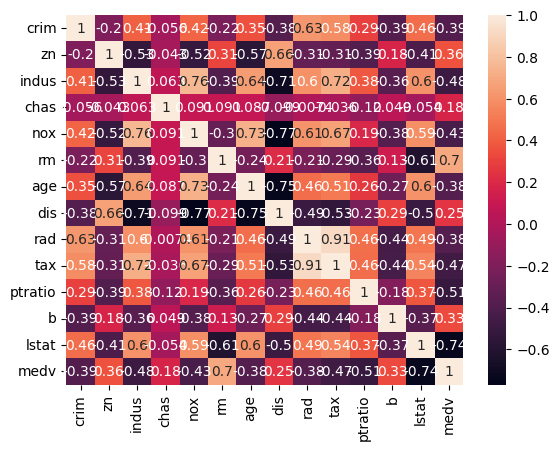

In [138]:
# gerando a matriz de correlação das features
corr = dataset_BH.corr(method = 'pearson')
sn.heatmap(corr, annot=True)
plt.show()

In [139]:
# podemos ver que a feature com maior correlação com o valor médio,
# que é nosso atributo de saída, é a feature lstat.
# portanto, por mais que ela seja inversamente proporcional, será esta feature
# a usada no modelo de regressão.
features = ["lstat"]
X = dataset_BH[features]
y = dataset_BH.medv

In [140]:
X.head()

,lstat
0,4.98
1,9.14
2,4.03
3,2.94
4,5.33


In [141]:
y.head()

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: medv, dtype: float64

In [142]:
# função que gera os conjuntos de treino e teste de forma pseudo-aleatória
def generateTrainTest(X, y):
  rnd = np.random.randint(1000)
  return train_test_split(X, y, test_size=0.30, random_state=rnd)

# função que retorna a Residual sum of squares
def RSS(y, y_pred):
  sum = 0
  for y, yp in zip(y, y_pred):
    sum += (y - yp)**2
  return sum

# função que retorna a Residual sum of squares
def RSE(y, y_pred, model_n_params = 2):
  return np.sqrt(RSS(y, y_pred)/(len(y)-model_n_params))

# função que retorna o Standard error para theta0
def SETheta0(X, rse):
  sum = 0
  for x in X:
    sum += (x - X.mean())**2
  return rse * np.sqrt(1/len(X) + (X.mean()**2)/sum)

# função que retorna o Standard error para theta1
def SETheta1(X, rse):
  sum = 0
  for x in X:
    sum += (x - X.mean())**2
  return rse * np.sqrt(1/sum)

# função que retorna R-squared ajustado,
# onde n = número de instâncias no conjunto e
# k = número de variáveis de entrada
def R_sq_Adjusted(n, k, RSquared):
  return 1-((1-RSquared)*(n-1)/(n-k-1))


In [143]:
# colunas do df para guardar os resultados
columns = ['Coeficiente','Intercept','Equação','RSS (Residual Sum of Squares)',
         'RSE (Residual Standard Error)','SE (Standard Error) para Theta 0',
         'SE (Standard Error) para Theta 1','R-squared', 'R-sq-Adjusted', 't-statistics', 'P-value']
lInfo = []

In [144]:
# número de subconjuntos
N_sub = 30

# inicializando variáveis auxiliares
residuals = []
fitted_val = []

In [145]:
for i in range(1,N_sub+1):
  #print("Run", i)
  X_train, X_test, y_train, y_test = generateTrainTest(X, y)
  # constroi o modelo
  model = LinearRegression()

  # treina o modelo
  model.fit(X_train, y_train)

  # faz predição sobre o conjunto de TREINO, para observar os erros
  y_pred = model.predict(X_train)

  # informações para inserir no df
  coef = model.coef_[0]
  intercept = model.intercept_
  eq = "y = " + str(coef) + " * X + " + str(intercept)
  RSSv = RSS(y_train, y_pred)
  RSEv = RSE(y_train, y_pred)
  SETheta0v = SETheta0(X_train['lstat'], RSEv)
  SETheta1v = SETheta1(X_train['lstat'], RSEv)
  RSquared = model.score(X_train, y_train)
  RSqAdj = R_sq_Adjusted(len(X_train), 1, RSquared)
  # t-stats para o teste de hipótese, onde
  # a hipótese nula = Não existe relação entre X e y (Theta1 = 0)
  # "Sample mean (theta 1) minus population mean you are comparing your sample to (0),
  # divided by the standard error (SETheta1v).
  t_stats = (coef - 0)/SETheta1v
  P_value = f_regression(X_train, y_train)[1][0]

  # informações adicionais
  residuals = y_train - y_pred
  fitted_val = y_pred

  lInfo.append(pd.Series([coef, intercept, eq, RSSv, RSEv, SETheta0v, SETheta1v, RSquared, RSqAdj, t_stats, P_value], index=columns))

In [146]:
# criando o df
df = pd.DataFrame(lInfo)
df

,Coeficiente,Intercept,Equação,RSS (Residual Sum of Squares),RSE (Residual Standard Error),SE (Standard Error) para Theta 0,SE (Standard Error) para Theta 1,R-squared,R-sq-Adjusted,t-statistics,P-value
0,-0.947191,34.583552,y = -0.9471914264651589 * X + 34.58355211485013,14298.862572,6.373521,0.695219,0.048155,0.523609,0.522255,-19.669472,1.228589e-58
1,-0.946785,34.642297,y = -0.9467848024207007 * X + 34.64229685667552,13053.026256,6.089537,0.661011,0.044579,0.561685,0.560439,-21.238521,5.094675e-65
2,-0.950037,34.678640,y = -0.9500366285733326 * X + 34.6786401751831,14047.632880,6.317282,0.673441,0.046121,0.546573,0.545285,-20.598801,2.012719e-62
3,-0.921739,34.080190,y = -0.9217385516941868 * X + 34.08018996366832,12911.553556,6.056447,0.660009,0.044280,0.551770,0.550497,-20.816139,2.633919e-63
4,-0.957245,34.705089,y = -0.9572454865047049 * X + 34.70508890942711,14044.716688,6.316626,0.675947,0.046260,0.548832,0.547550,-20.692915,8.341010e-63
5,-0.965076,34.982551,y = -0.9650760193306918 * X + 34.982550917585606,14755.070410,6.474397,0.699380,0.048054,0.533982,0.532658,-20.083229,2.525569e-60
6,-0.998642,35.413241,y = -0.9986416377068181 * X + 35.413241286771466,14710.053180,6.464513,0.690652,0.047836,0.553201,0.551932,-20.876446,1.498675e-63
7,-0.968898,34.794604,y = -0.9688984229601445 * X + 34.79460370569241,13682.108331,6.234551,0.664247,0.046781,0.549274,0.547993,-20.711401,7.016127e-63
8,-0.984878,34.899891,y = -0.9848775569645133 * X + 34.89989138372746,13958.361840,6.297177,0.688077,0.047972,0.544918,0.543625,-20.530145,3.827962e-62
9,-0.928097,34.123150,y = -0.9280969513331357 * X + 34.12314993113344,13870.581906,6.277345,0.683771,0.046383,0.532151,0.530821,-20.009469,5.045935e-60


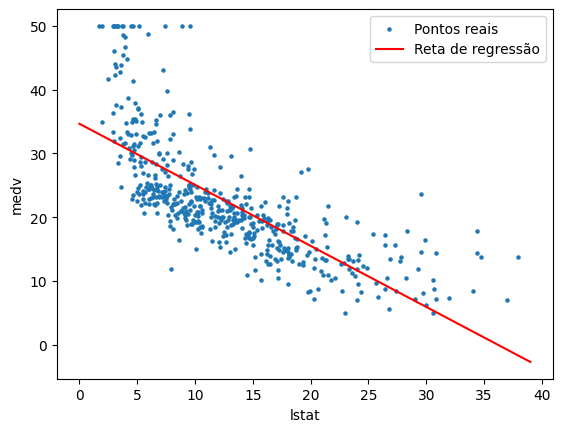

In [147]:
# plotando os resultados:

# plotando os pontos
pts = plt.scatter(X['lstat'], y, s= 5, label = 'Pontos reais')

# plotando a reta obtida pela média dos 30 valores theta 0 e 1
med_t0 = df['Intercept'].mean()
med_t1 = df['Coeficiente'].mean()
reg_x = range(40)
reg_y = med_t0 + med_t1*reg_x
reg = plt.plot(reg_x, reg_y, color = 'red', label = 'Reta de regressão')

# finalziando o plot
plt.xlabel('lstat') #x label
plt.ylabel('medv') #y label
plt.legend()
plt.show()

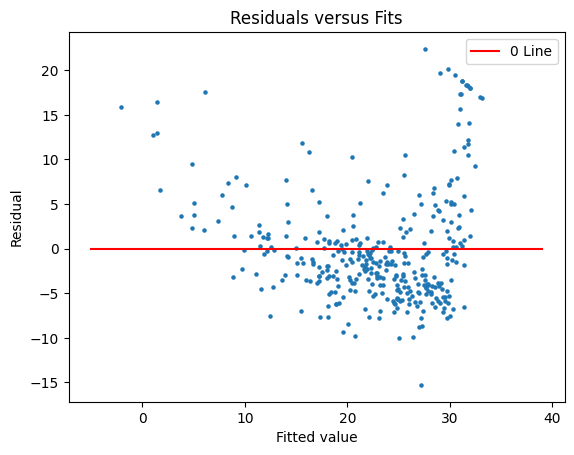

In [148]:
# Determinando se um valor de R-Squared é bom...
# isso pode ser feito ao plotar o gráfico Residuals x Fit
# verificando se os resíduos são consistestes com o random error, ou seja, o modelo não está enviesado

# plotando os pontos
pts = plt.scatter(fitted_val, residuals, s= 5)
# plotando a linha
line = plt.plot(range (-5, 40), np.zeros(45), color = 'red', label = '0 Line')
# finalziando o plot
plt.title('Residuals versus Fits')
plt.xlabel('Fitted value') #x label
plt.ylabel('Residual') #y label
plt.legend()
plt.show()

In [149]:
# Note que os resíduos não estão tão distribuídos de acordo com o random error,
# portanto, isso indica certa necessidade de alterção no modelo.
df['R-squared'].mean()
# isso pode significar que nossa métrica obtida com R-squared seja um valor pior do que o percebido


0.5450053729042903

In [150]:
# exportando o dataframe obtido
df.to_csv('/content/sample_data/BostonHousing_results.csv', index=False)

In [151]:
#----------------------------------------------------------------------------------------------
# Podemos tentar normalizar a feature de entrada para tentar obter algum ganho com as métricas
#----------------------------------------------------------------------------------------------

# resetando a lista para construir o dataframe
lInfo = []

In [152]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X, y)
# tentando algum resultado diferente com a normalização dos dados
for i in range(1,N_sub+1):
  #print("Run", i)
  X_train, X_test, y_train, y_test = generateTrainTest(X_norm, y)
  # constroi o modelo
  model = LinearRegression()

  # treina o modelo
  model.fit(X_train, y_train)

  # faz predição sobre o conjunto de TREINO, para observar os erros
  y_pred = model.predict(X_train)

  # informações para inserir no df
  coef = model.coef_[0]
  intercept = model.intercept_
  eq = "y = " + str(coef) + " * X + " + str(intercept)
  RSSv = RSS(y_train, y_pred)
  RSEv = RSE(y_train, y_pred)
  SETheta0v = SETheta0(X_train, RSEv)
  SETheta1v = SETheta1(X_train, RSEv)
  RSquared = model.score(X_train, y_train)
  RSqAdj = R_sq_Adjusted(len(X_train), 1, RSquared)
  # t-stats para o teste de hipótese, onde
  # a hipótese nula = Não existe relação entre X e y (Theta1 = 0)
  # "Sample mean (theta 1) minus population mean you are comparing your sample to (0),
  # divided by the standard error (SETheta1v).
  t_stats = (coef - 0)/SETheta1v
  P_value = f_regression(X_train, y_train)[1][0]

  # informações adicionais
  residuals = y_train - y_pred
  fitted_val = y_pred

  lInfo.append(pd.Series([coef, intercept, eq, RSSv, RSEv, SETheta0v, SETheta1v, RSquared, RSqAdj, t_stats, P_value], index=columns))

In [153]:
# criando o df
df = pd.DataFrame(lInfo)
df

,Coeficiente,Intercept,Equação,RSS (Residual Sum of Squares),RSE (Residual Standard Error),SE (Standard Error) para Theta 0,SE (Standard Error) para Theta 1,R-squared,R-sq-Adjusted,t-statistics,P-value
0,-35.368788,33.221302,y = -35.36878845579721 * X + 33.221301709169026,13675.103923,6.232955,[0.6112149133933128],[1.7148334325557013],0.547208,0.545922,[-20.625203465438243],1.571961e-62
1,-34.690576,33.049054,y = -34.69057643093052 * X + 33.04905421777398,14044.716688,6.316626,[0.6077879924348626],[1.6764470199557133],0.548832,0.547550,[-20.692915444382454],8.341010e-63
2,-33.611392,32.663814,y = -33.611391643131626 * X + 32.66381352576872,13807.105444,6.262965,[0.6064335573725418],[1.6614181361155385],0.537618,0.536304,[-20.230543360816075],6.342771e-61
3,-34.390897,33.078687,y = -34.39089678233987 * X + 33.07868748068741,14922.813651,6.511095,[0.6238113163514969],[1.720345958107512],0.531683,0.530352,[-19.990686536196478],6.018599e-60
4,-35.193596,33.080961,y = -35.19359575866563 * X + 33.08096050149956,13213.411185,6.126834,[0.5934144231018761],[1.6600140183711296],0.560809,0.559561,[-21.20078226399495],7.245098e-65
5,-33.504831,32.523979,y = -33.50483060032655 * X + 32.523979349089544,13856.361735,6.274127,[0.598770016799045],[1.6697064881504666],0.533563,0.532237,[-20.066299579059454],2.960349e-60
6,-34.969718,32.568786,y = -34.96971791900675 * X + 32.568786476344215,11302.270615,5.666456,[0.5742708267437435],[1.6148448530908814],0.571226,0.570008,[-21.65515643937758],1.050025e-66
7,-35.009220,33.187530,y = -35.00921994745193 * X + 33.18753022731434,13580.718788,6.211408,[0.6021975243068521],[1.6709357548810237],0.554983,0.553719,[-20.9518647531393],7.405614e-64
8,-32.349868,32.079718,y = -32.34986825658426 * X + 32.07971793577136,12492.921771,5.957454,[0.579178543731321],[1.6237473238619264],0.529993,0.528658,[-19.922969406128544],1.136414e-59
9,-34.663270,33.135442,y = -34.663269974513376 * X + 33.13544182664604,13376.408397,6.164508,[0.5922432579851161],[1.6322043407075533],0.561651,0.560406,[-21.237089689080843],5.163174e-65


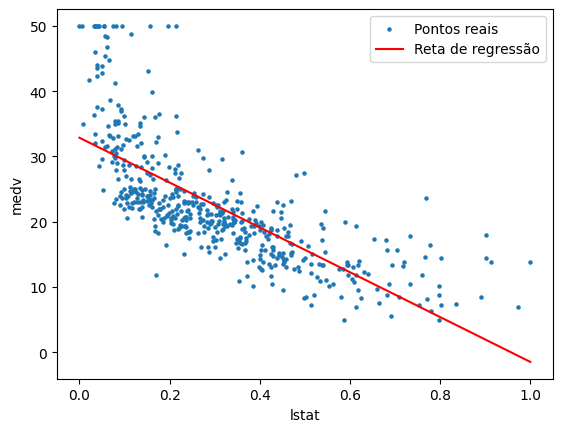

In [154]:
# plotando os resultados:

# plotando os pontos
pts = plt.scatter(X_norm, y, s= 5, label = 'Pontos reais')

# plotando a reta obtida pela média dos 30 valores theta 0 e 1
med_t0 = df['Intercept'].mean()
med_t1 = df['Coeficiente'].mean()
reg_x = np.arange(0.0,1.1,0.1)
reg_y = med_t0 + med_t1*reg_x
reg = plt.plot(reg_x, reg_y, color = 'red', label = 'Reta de regressão')

# finalziando o plot
plt.xlabel('lstat') #x label
plt.ylabel('medv') #y label
plt.legend()
plt.show()

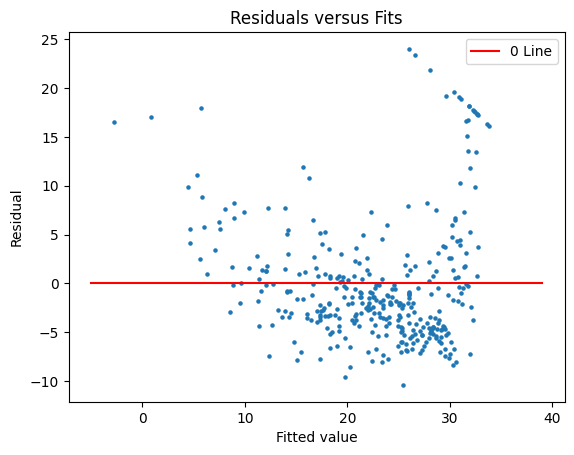

In [155]:
# Determinando se um valor de R-Squared é bom...
# isso pode ser feito ao plotar o gráfico Residuals x Fit
# verificando se os resíduos são consistestes com o random error, ou seja, o modelo não está enviesado

# plotando os pontos
pts = plt.scatter(fitted_val, residuals, s= 5)
# plotando a linha
line = plt.plot(range (-5, 40), np.zeros(45), color = 'red', label = '0 Line')
# finalziando o plot
plt.title('Residuals versus Fits')
plt.xlabel('Fitted value') #x label
plt.ylabel('Residual') #y label
plt.legend()
plt.show()

In [156]:
# Note que os resíduos não estão tão distribuídos de acordo com o random error,
# portanto, isso indica certa necessidade de alterção no modelo.
df['R-squared'].mean()
# isso pode significar que nossa métrica obtida com R-squared seja um valor pior do que o percebido


0.5476961546893204

In [157]:
# finalizando a análise após a normalização da feature, não conseguimos muitos ganhos para o modelo.